In [61]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import environment
import td
from constants import BOOTSTRAP_SARSA, BOOTSTRAP_EXPECTED, BOOTSTRAP_Q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
def to_arrow(pi):
    directions = []
    arrows = ["↑", "→", "↓", "←"]
    for actions in pi:
        for i in range(len(actions)):
            if actions[i] > 0:
                directions.append(arrows[i])
    
    return directions

def run(grid, agent, n_runs=25):
    grid_actions = 4
    # env
    env = environment.create(grid=grid, step_reward=-1, cliff_reward=-100)

    # S, A
    n_row = len(grid)
    n_col = len(grid[0])
    S = [s for s in range(n_row * n_col)]
    A = [a for a in range(grid_actions)]
    
    bootstraps = [BOOTSTRAP_SARSA, BOOTSTRAP_EXPECTED, BOOTSTRAP_Q]
    results = []
    
    for bootstrap in bootstraps:
        agent["bootstrap"] = bootstrap
        error_histories = []
        length_histories = []
        visit_counts = []
        q, pi = None, None
        
        for i in tqdm(range(n_runs)):
            q, pi, log = td.learn(S, A, env, agent)
            error_history, length_history, visit_count = log
            
            error_histories.append(error_history)
            length_histories.append(length_history)
            visit_counts.append(visit_count)
        
        results.append((bootstrap, np.average(error_histories, axis=0), 
                        np.average(length_histories, axis=0), np.average(visit_counts, axis=0)))
    
    return results

plt.rcParams['figure.figsize'] = [10, 5]

def plot(title, data):
    for d in data:
        plt.plot(d[1], label=d[0])
    plt.title(title)
    plt.legend()
    plt.show()
    
def print_visit_count(data, n_row, n_col):
    print("visit count last 20 episodes")
    for d in data:
        print(d[0])
        print(d[1].reshape(n_row, n_col))


100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


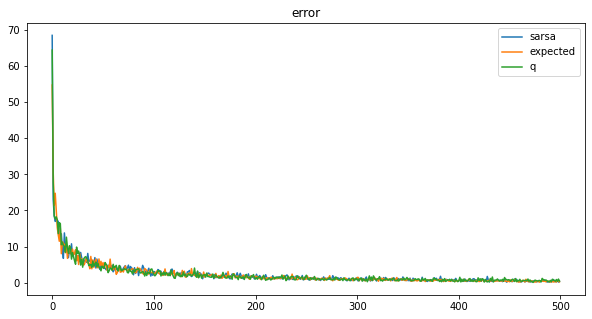

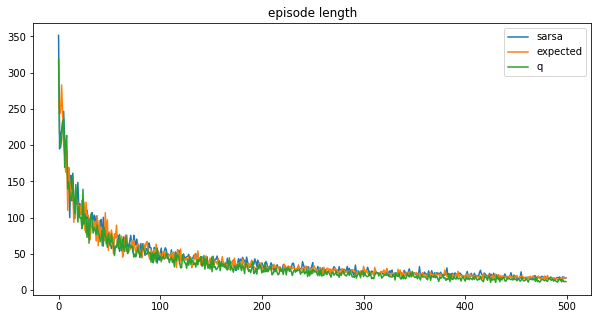

visit count last 20 episodes
sarsa
[[ 4.24  4.12  4.    3.44  3.2   2.6   1.92]
 [ 5.44  4.76  3.88  3.56  3.08  2.48  1.92]
 [ 7.32  6.68  5.16  4.52  4.    3.44  4.08]
 [20.8  17.   16.68 15.88 16.24 16.12 17.52]
 [22.64  2.96  2.48  1.04  1.28  3.4  19.72]
 [22.64  0.    0.    0.    0.    0.   19.  ]
 [ 7.84  2.92  1.36  1.    1.04  0.8   0.8 ]]
expected
[[ 5.32  4.76  4.48  3.72  3.52  2.6   1.6 ]
 [ 5.76  4.96  4.28  3.72  3.04  2.48  1.92]
 [ 8.08  6.    4.96  4.48  4.04  3.92  3.68]
 [20.   15.08 14.08 13.6  14.4  15.2  17.92]
 [22.12  3.24  2.04  1.44  1.24  1.8  18.88]
 [21.96  0.    0.    0.    0.    0.   19.  ]
 [ 6.92  2.88  2.48  2.24  1.88  1.6   1.48]]
q
[[ 2.52  2.36  2.28  1.92  1.52  1.44  1.28]
 [ 2.96  2.92  2.68  2.24  1.48  1.48  1.36]
 [ 3.4   3.08  2.72  2.6   1.96  1.72  1.36]
 [ 4.68  3.4   3.08  2.68  2.36  1.84  2.12]
 [13.92 10.4   9.52  9.    9.28  9.76 11.  ]
 [24.72  0.    0.    0.    0.    0.   19.  ]
 [12.48 11.12 10.36 10.4  10.24  9.88  9.36]]


In [70]:
# online learning without background planning
grid = [
    ".......",
    ".......",
    ".......",
    ".......",
    ".......",
    "SCCCCCT",
    "......."
]
n_row = len(grid)
n_col = len(grid[0])

# agent
agent = {
    "discount": 0.9,
    "step_size": 0.05,
    "epsilon": 0.1,
    "trace_length": 3,
    "n_iterations": 500,
    "learn_online": True,
    "plan_background": False
}

results = run(grid, agent, 25)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])
print_visit_count([(result[0], result[3]) for result in results], n_row, n_col)


100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


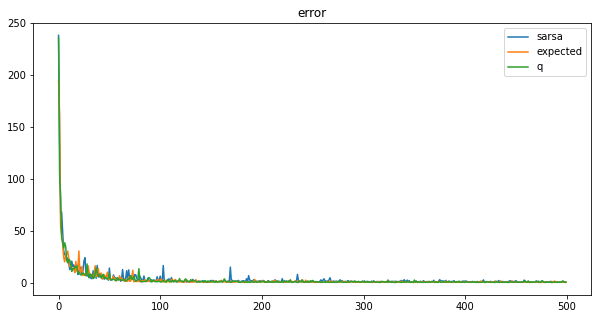

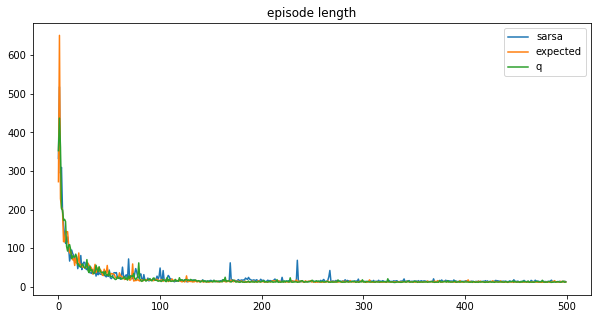

visit count last 20 episodes
sarsa
[[ 0.72  0.76  0.72  0.48  0.68  0.8   0.16]
 [ 0.68  1.24  1.48  0.96  0.8   1.12  0.6 ]
 [ 8.68  9.68  9.92  9.68 10.    7.64  4.84]
 [20.4  12.32 12.32 12.56 14.16 16.24 19.52]
 [20.24  0.56  0.4   0.72  0.64  1.84 20.32]
 [20.72  0.    0.    0.    0.    0.   19.  ]
 [ 0.8   0.04  0.    0.    0.    0.    0.  ]]
expected
[[ 0.36  0.92  1.04  0.56  0.56  0.48  0.16]
 [ 0.88  0.84  0.76  0.56  0.56  0.4   0.6 ]
 [ 0.8   1.68  1.68  1.48  1.4   1.2   1.08]
 [20.4  20.16 19.44 19.16 18.96 19.16 19.92]
 [20.84  1.36  0.88  0.76  0.68  1.36 20.52]
 [20.96  0.    0.    0.    0.    0.   19.  ]
 [ 5.28  2.24  0.16  0.12  0.12  0.08  0.08]]
q
[[ 0.2   0.32  0.56  0.08  0.12  0.12  0.12]
 [ 0.36  0.24  0.36  0.24  0.28  0.2   0.12]
 [ 0.76  0.84  1.36  1.6   1.4   1.32  1.2 ]
 [20.04 19.96 20.08 20.28 19.88 19.92 19.84]
 [21.04  1.64  0.92  1.36  1.    1.4  20.08]
 [20.92  0.    0.    0.    0.    0.   19.  ]
 [ 1.36  1.    1.64  0.96  0.08  0.16  0.16]]


In [75]:
# online learning with background planning
agent["plan_background"] = True
agent["trace_length"] = 3

results = run(grid, agent, 25)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])
print_visit_count([(result[0], result[3]) for result in results], n_row, n_col)
